In [8]:
import argparse
import math
import time

import torch
import torch.nn as nn
import DCM_DeepCausal0626
import numpy as np
#import importlib
from utils0626_realdata_PAKDD import *
import Optim
import scipy
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.io as sio
from numpy import linalg as LA
from sklearn import preprocessing

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import normalized_mutual_info_score, accuracy_score
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

class args:
    data_path = '../../../../ExperimentData/PAKDD_data/preprocessed/'
    data_name = 'JapaneseVowels'
    
    train = 0.80
    model = 'DCM_DeepCausal0626'
    
    window = 5
    pre_win = 2
    p_list = [5]*5
    lp_list = [20]*5  #lp means large p
    reduce_dim = 50

    low_rank = 5
    
    clip = 1.
    epochs = 30
    batch_size = 32
    dropout = 0.1
    seed = 12345
    gpu = 0

    cuda = False
    optim = 'adam'
    lr = 0.01
    weight_decay = 0
    horizon = 1
    random_shuffle = True    
    
    cos_sim_reg_type = 'USV'
   # cos_sim_reg_type = 'A'
   # cos_sim_reg_type = 'None'
    cos_lambda = 1.    

#    graph_init = 'epsilon'
    graph_batchnorm = True
    graph_init = 'uniform'
    
    copula = True
    normalize = True


np.random.seed(args.seed)
#random.seed(manualSeed)
torch.manual_seed(args.seed)
if args.cuda is True:
    torch.cuda.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.enabled = False 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

if args.cuda:
    torch.cuda.set_device(args.gpu)
# Set the random seed manually for reproducibility.
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
    else:
        torch.cuda.manual_seed(args.seed)

Data = Data_utility(args)

args.NumCluster = Data.NumCluster

print('buliding model')
model = eval(args.model).Model(args, Data)

if args.cuda:
    model.cuda()

nParams = sum([p.nelement() for p in model.parameters()])
print('* number of parameters: %d' % nParams)

criterion = nn.MSELoss(size_average=True, reduce=False) #Take the sum, not the average
if args.cuda:
    criterion = criterion.cuda()

optim = Optim.Optim(
    model.parameters(), args.optim, args.lr, args.clip, weight_decay = args.weight_decay,
)

def cos_similarity(a, b):
    return torch.abs(torch.dot(a,b) / (torch.sqrt(torch.dot(a,a)) * torch.sqrt(torch.dot(b,b))))

def find_permutation(n_clusters, real_labels, labels):
    permutation=[]
    for i in range(n_clusters):
        idx = labels == i
        new_label=scipy.stats.mode(real_labels[idx])[0][0]  # Choose the most common label among data points in the cluster
        permutation.append(new_label)
    return permutation

    
def evaluate(loader, data, model, criterion, args):
    total_loss = 0    
    total_loss_reg = 0
    n_samples = 0        
    total_time = 0
    
    pred_labels = []
    new_soft_vectors = []
    true_label_all = []
    
    residuals_alldim_all = [ [] for _ in range(args.NumCluster) ]

    for inputs in loader.get_batches(data, args.batch_size, False):                
        begin_time = time.time()
        
        [X, Y, true_label, seg_len] = inputs #Y: (batchsize, prewin, m)
        true_label_all.append(true_label)
        
        batch_size = X[0].shape[0]
        
        Y_hat_list = model(X, seg_len)
        residuals = torch.zeros((batch_size, args.NumCluster))
    
        Mask = torch.zeros(Y.shape)
        batchwiseTotalSeg = np.sum(seg_len)      
        for batch_i in range(batch_size):
            Mask[batch_i,:seg_len[batch_i],:,:] = 1
            
        for cluster_i in range(args.NumCluster):
            residuals_tmp = criterion(Y_hat_list[cluster_i]*Mask, Y*Mask)
            residuals[:, cluster_i] = torch.sum( residuals_tmp, dim=(1,2,3) )
            residuals_alldim_all[cluster_i].append(residuals_tmp.detach().numpy())

        new_soft_vectors.append(residuals)
        
        loss_reg = torch.sum(torch.min(residuals, dim=1)[0]) / (args.pre_win * batchwiseTotalSeg * Data.m)
        pred_labels.append(torch.min(residuals, dim=1)[1])
        
        batch_loss = loss_reg        
                                            
        total_loss += batch_loss.data.item()
        total_loss_reg += loss_reg.data.item()    
        total_time = total_time + time.time() - begin_time  
        
        n_samples += batch_size

    total_loss /= (n_samples)
    total_loss_reg /= (n_samples)
        
    true_labels = np.concatenate(true_label_all, axis = 0)
    pred_labels = (torch.cat(pred_labels, dim = 0)).detach().numpy()

    new_soft_vectors = (torch.cat(new_soft_vectors, dim = 0)).detach().numpy()
    new_soft_vectors = preprocessing.scale(new_soft_vectors)

    GMM_model = GaussianMixture(n_components=args.NumCluster, reg_covar=1e-11)
    GMM_model.fit(new_soft_vectors) 
    GMM_labels = GMM_model.predict(new_soft_vectors)        

    KM_model = KMeans(n_clusters=args.NumCluster, n_init=30, random_state=np.random.randint(0, 500), tol = 1e-5)
    KM_labels = KM_model.fit(new_soft_vectors).labels_
    
    for clust_i in range(args.NumCluster):
        residuals_alldim_all[clust_i] = np.concatenate(residuals_alldim_all[clust_i], axis = 0)
        return total_time, total_loss, total_loss_reg, n_samples, KM_labels, GMM_labels, pred_labels, true_labels


def train(loader, data, model, criterion, optim, args):
    model.train()

    total_loss = 0    
    total_loss_reg = 0
    total_loss_cos = 0
    n_samples = 0        
    total_time = 0
    
    count = 0
    
    pred_labels = []
    new_soft_vectors = []
    true_label_all = []    

    residuals_alldim_all = [ [] for _ in range(args.NumCluster) ]

    for inputs in loader.get_batches(data, args.batch_size, True):                
        begin_time = time.time()
        
        [X, Y, true_label, seg_len] = inputs #Y: (batchsize, prewin, m)
        true_label_all.append(true_label)
        
        batch_size = X[0].shape[0]
        model.zero_grad()
        
        Y_hat_list = model(X, seg_len)
        residuals = torch.zeros((batch_size, args.NumCluster))

        Mask = torch.zeros(Y.shape)
        batchwiseTotalSeg = np.sum(seg_len)
        for batch_i in range(batch_size):
            Mask[batch_i,:seg_len[batch_i],:,:] = 1
        
        MaxSeg = Y.shape[1]
        
        for cluster_i in range(args.NumCluster):
            residuals_tmp = criterion(Y_hat_list[cluster_i]*Mask, Y*Mask)
            
            eigvalues = model.graph_net[cluster_i][2].weight.detach().numpy() 
            MaxEigIdx = np.argmax(eigvalues)
            feat = torch.abs(model.graph_net[cluster_i][3].weight[:,MaxEigIdx]) #(m)
            
            feat = 1 - F.normalize(feat, p=2, dim=0, eps=1e-5)
            feat = F.normalize(feat, p=2, dim=0, eps=1e-5)
            
            #feat = F.normalize(feat, p=2, dim=0, eps=1e-5)
            
            
            weight_tmp = feat.repeat(batch_size, MaxSeg, args.pre_win, 1)  #(batchsize, seg, prewin, m) same shape as Y
            residuals_tmp = torch.mul(residuals_tmp, weight_tmp)
            
            residuals[:, cluster_i] = torch.sum(residuals_tmp, dim=(1,2,3))
            residuals_alldim_all[cluster_i].append(residuals_tmp.detach().numpy())

        new_soft_vectors.append(residuals)
        loss_reg = torch.sum(torch.min(residuals, dim=1)[0]) / (args.pre_win * batchwiseTotalSeg * Data.m) 
        pred_labels.append(torch.min(residuals, dim=1)[1])
        
        Cos_loss = torch.tensor(0.0)
        graph_tensor_list = []
        
        if args.cos_sim_reg_type == 'USV':
            for i_i in range(args.NumCluster):
                graph_tensor_list_clst = []
                
                if args.graph_init == 'uniform':
                    graph_tensor_list_clst.append(model.graph_net[i_i][0].weight.flatten())
                    graph_tensor_list_clst.append(model.graph_net[i_i][2].weight.flatten())
                    graph_tensor_list_clst.append(model.graph_net[i_i][3].weight.flatten())            
                else:
                    graph_tensor_list_clst.append(model.graph_net[i_i].U.flatten())
                    graph_tensor_list_clst.append(model.graph_net[i_i].S.flatten())
                    graph_tensor_list_clst.append(model.graph_net[i_i].V.flatten())
                    
                graph_tensor_clst = torch.cat(graph_tensor_list_clst)
                graph_tensor_list.append(graph_tensor_clst)

        elif args.cos_sim_reg_type == 'A':               
            for i_i in range(args.NumCluster):        
                A = model.graph_net[i_i][0].weight.transpose(0,1)
                B = torch.diag(model.graph_net[i_i][2].weight.squeeze())
                C = model.graph_net[i_i][3].weight.transpose(0,1)
                
                CGraph = torch.abs(torch.matmul(torch.matmul(A,B),C))
                CGraph[range(model.m), range(model.m)] = 0.0                    
                graph_tensor_clst = CGraph.flatten()
                
                graph_tensor_list.append(graph_tensor_clst)
        
        if len(graph_tensor_list) > 0:
            for i_i in range(args.NumCluster - 1):
                for j_i in range(i_i+1, args.NumCluster):
                    Cos_loss += cos_similarity(graph_tensor_list[i_i], graph_tensor_list[j_i])           

        batch_loss = loss_reg + args.cos_lambda*Cos_loss       
        
   #     torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
                                    
        batch_loss.backward(retain_graph = True)
        total_loss += batch_loss.data.item()
        total_loss_reg += loss_reg.data.item()    
        total_loss_cos += Cos_loss.data.item()    

        total_time = total_time + time.time() - begin_time  
        
        optim.step()
        n_samples += batch_size
        count += 1

    total_loss /= (n_samples)
    total_loss_reg /= (n_samples)
    total_loss_cos /= count

    true_labels = np.concatenate(true_label_all, axis = 0)
    pred_labels = (torch.cat(pred_labels, dim = 0)).detach().numpy()

    for clust_i in range(args.NumCluster):
        residuals_alldim_all[clust_i] = np.concatenate(residuals_alldim_all[clust_i], axis = 0)

    new_soft_vectors = (torch.cat(new_soft_vectors, dim = 0)).detach().numpy()
    new_soft_vectors_norm = preprocessing.scale(new_soft_vectors)

    GMM_model = GaussianMixture(n_components=args.NumCluster, reg_covar=1e-11)
    GMM_model.fit(new_soft_vectors_norm) 
    GMM_labels = GMM_model.predict(new_soft_vectors_norm)        

    KM_model = KMeans(n_clusters=args.NumCluster, n_init=30, random_state=np.random.randint(0, 500), tol = 1e-5)
    KM_labels = KM_model.fit(new_soft_vectors_norm).labels_

    return total_time, total_loss, total_loss_reg, total_loss_cos, n_samples, KM_labels, GMM_labels, pred_labels, true_labels, new_soft_vectors, residuals_alldim_all

print("begin training")
total_loss_set1 = []
total_loss_reg_set1 = []
total_loss_cos_set1 = []
total_loss_set2 = []
total_loss_reg_set2 = []

residuals_set = []

for epoch in range(0, args.epochs):
    epoch_time, total_loss1, total_loss_reg1, total_loss_cos1, n_samples1, KM_labels1, GMM_labels1, pred_labels1, true_labels1, residuals, residuals_alldim = train(Data, Data.train, model, criterion, optim, args)
    _, total_loss2, total_loss_reg2, n_samples2, KM_labels2, GMM_labels2, pred_labels2, true_labels2 = evaluate(Data, Data.valid, model, criterion, args)
    
    total_loss_set1.append(total_loss1)
    total_loss_reg_set1.append(total_loss_reg1)
    total_loss_cos_set1.append(total_loss_cos1)
    total_loss_set2.append(total_loss2)
    total_loss_reg_set2.append(total_loss_reg2)

    residuals_set.append(residuals)

    CGraph_list = model.predict_relationship_inside()[0]
    AUPR_list = []
    AUROC_list = []

    if epoch == 0:
        print('Training Samples per cluster {:3d}, Testing Samples {:3d}'.format(n_samples1 // args.NumCluster, n_samples2 // args.NumCluster))
        print('Number of Clusters {:3d}'.format(args.NumCluster))
        
    print('Epoch {:3d}|time:{:5.2f}s|total_loss_train:{:5.4f}|regression_loss_train:{:5.4f}|cos_reg_loss_train:{:5.4f}|total_loss_test:{:5.4f}|regression_loss_test:{:5.4f}|'.format(epoch, epoch_time, total_loss1, total_loss_reg1, total_loss_cos1, total_loss2, total_loss_reg2))

    KM_NMI1 = normalized_mutual_info_score(true_labels1, KM_labels1)
    GMM_NMI1 = normalized_mutual_info_score(true_labels1, GMM_labels1)
    min_res_NMI1 = normalized_mutual_info_score(true_labels1, pred_labels1)

    KM_NMI2 = normalized_mutual_info_score(true_labels2, KM_labels2)
    GMM_NMI2 = normalized_mutual_info_score(true_labels2, GMM_labels2)
    min_res_NMI2 = normalized_mutual_info_score(true_labels2, pred_labels2)


    if epoch > 100:
        permutation1 = find_permutation(args.NumCluster, true_labels1, pred_labels1)
        permutation2 = find_permutation(args.NumCluster, true_labels2, pred_labels2)
    else:
        permutation1 = np.array(range(args.NumCluster))
        permutation2 = np.array(range(args.NumCluster))

    new_labels1 = [ permutation1[label] for label in pred_labels1]   # permute the labels 
    min_res_ACC1 = accuracy_score(true_labels1, new_labels1)

    new_labels2 = [ permutation2[label] for label in pred_labels2]   # permute the labels 
    min_res_ACC2 = accuracy_score(true_labels2, new_labels2)
        
    print('|Kmeans_NMI_trn:{:5.3f}|GMM_NMI_trn:{:5.3f}|MinRes_NMI_trn:{:5.3f}|MinRes_ACC_trn:{:5.3f}'.format(KM_NMI1, GMM_NMI1, min_res_NMI1, min_res_ACC1))
    print('|Kmeans_NMI_tst:{:5.3f}|GMM_NMI_tst:{:5.3f}|MinRes_NMI_tst:{:5.3f}|MinRes_ACC_tst:{:5.3f}'.format(KM_NMI2, GMM_NMI2, min_res_NMI2, min_res_ACC2))
    
    for cluster_i in range(len(CGraph_list)):
        CGraph = CGraph_list[cluster_i].reshape(model.m*model.m).detach().numpy()

    print("#"*20)

buliding model
* number of parameters: 27224
begin training
Training Samples per cluster  71, Testing Samples  71
Number of Clusters   9
Epoch   0|time: 6.87s|total_loss_train:0.3295|regression_loss_train:0.0058|cos_reg_loss_train:10.3587|total_loss_test:0.0161|regression_loss_test:0.0161|
|Kmeans_NMI_trn:0.137|GMM_NMI_trn:0.163|MinRes_NMI_trn:0.195|MinRes_ACC_trn:0.139
|Kmeans_NMI_tst:0.164|GMM_NMI_tst:0.186|MinRes_NMI_tst:0.222|MinRes_ACC_tst:0.103
####################
Epoch   1|time: 6.55s|total_loss_train:0.0780|regression_loss_train:0.0042|cos_reg_loss_train:2.3625|total_loss_test:0.0135|regression_loss_test:0.0135|
|Kmeans_NMI_trn:0.190|GMM_NMI_trn:0.210|MinRes_NMI_trn:0.207|MinRes_ACC_trn:0.078
|Kmeans_NMI_tst:0.205|GMM_NMI_tst:0.264|MinRes_NMI_tst:0.212|MinRes_ACC_tst:0.075
####################
Epoch   2|time: 6.55s|total_loss_train:0.0172|regression_loss_train:0.0038|cos_reg_loss_train:0.4312|total_loss_test:0.0127|regression_loss_test:0.0127|
|Kmeans_NMI_trn:0.200|GMM_NMI_trn

Epoch  24|time: 6.57s|total_loss_train:0.0062|regression_loss_train:0.0029|cos_reg_loss_train:0.1055|total_loss_test:0.0103|regression_loss_test:0.0103|
|Kmeans_NMI_trn:0.242|GMM_NMI_trn:0.296|MinRes_NMI_trn:0.374|MinRes_ACC_trn:0.017
|Kmeans_NMI_tst:0.221|GMM_NMI_tst:0.261|MinRes_NMI_tst:0.372|MinRes_ACC_tst:0.017
####################
Epoch  25|time: 6.70s|total_loss_train:0.0061|regression_loss_train:0.0029|cos_reg_loss_train:0.1020|total_loss_test:0.0102|regression_loss_test:0.0102|
|Kmeans_NMI_trn:0.255|GMM_NMI_trn:0.310|MinRes_NMI_trn:0.370|MinRes_ACC_trn:0.023
|Kmeans_NMI_tst:0.244|GMM_NMI_tst:0.353|MinRes_NMI_tst:0.369|MinRes_ACC_tst:0.027
####################
Epoch  26|time: 6.66s|total_loss_train:0.0061|regression_loss_train:0.0029|cos_reg_loss_train:0.1014|total_loss_test:0.0102|regression_loss_test:0.0102|
|Kmeans_NMI_trn:0.242|GMM_NMI_trn:0.295|MinRes_NMI_trn:0.362|MinRes_ACC_trn:0.033
|Kmeans_NMI_tst:0.246|GMM_NMI_tst:0.298|MinRes_NMI_tst:0.356|MinRes_ACC_tst:0.027
#######

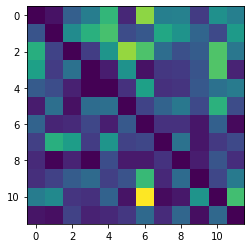

In [5]:
plt.imshow(CGraph.reshape((Data.m, Data.m)))

In [6]:
model.graph_net[0]

ModuleList(
  (0): Linear(in_features=12, out_features=5, bias=False)
  (1): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SV_Model()
  (3): Linear(in_features=5, out_features=12, bias=False)
  (4): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

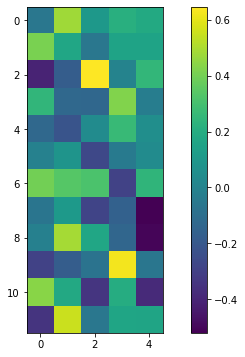

In [7]:
plt.figure(1,figsize=(10, 6))
plt.imshow(model.graph_net[0][0].weight.detach().numpy().transpose(1,0))
plt.colorbar()

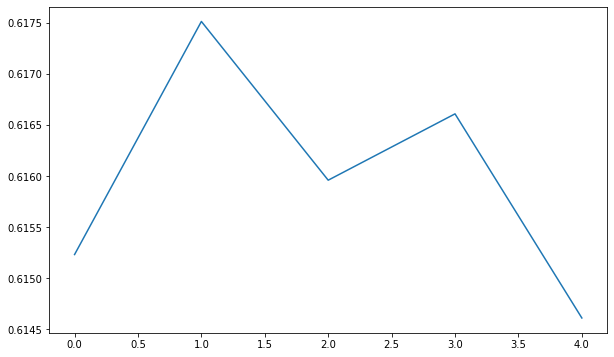

In [8]:
plt.figure(1,figsize=(10, 6))
plt.plot(model.graph_net[0][2].weight.detach().numpy())
#plt.colorbar()

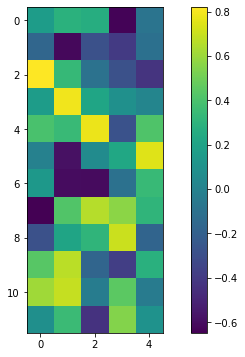

In [9]:
plt.figure(1,figsize=(10, 6))
plt.imshow(model.graph_net[0][3].weight.detach().numpy())
plt.colorbar()

In [10]:
rev_permutation2 = []
for cluster_i in range(args.NumCluster):
    rev_permutation2.append(np.where(np.array(permutation2)==cluster_i)[0][0])

Text(0, 0.5, 'Label')

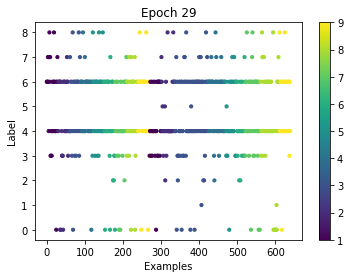

In [11]:
pred_labels_permu_2 = np.array([rev_permutation2[i] for i in pred_labels1])
plt.scatter(np.array(range(len(pred_labels_permu_2))), pred_labels_permu_2, c = true_labels2, s = 10)
plt.colorbar()
plt.title("Epoch " + str(epoch))
plt.xlabel('Examples')
plt.ylabel('Label')

Text(0, 0.5, 'loss')

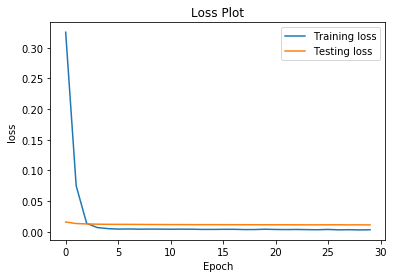

In [12]:
plt.plot(np.array(total_loss_set1))
#plt.plot(np.array(total_loss_reg_set1))
#plt.plot(np.array(total_loss_cos_set1))
plt.plot(np.array(total_loss_set2))
plt.legend(('Training loss', 'Testing loss'))
plt.title("Loss Plot")
plt.xlabel('Epoch')
plt.ylabel('loss')

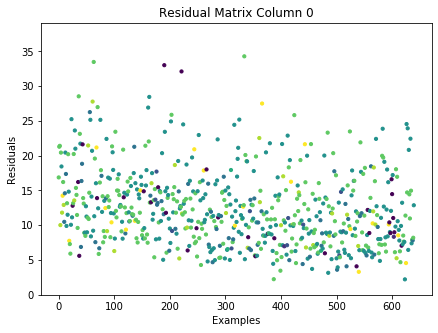

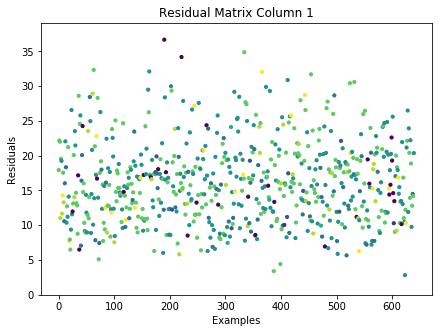

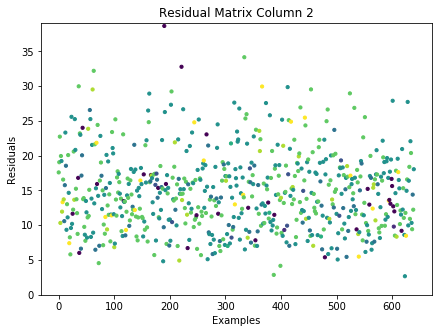

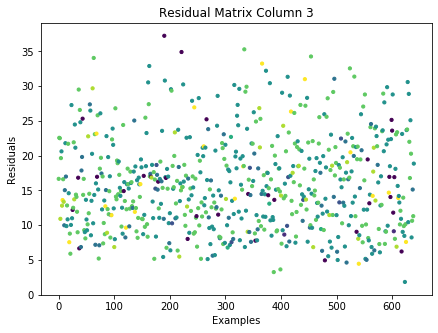

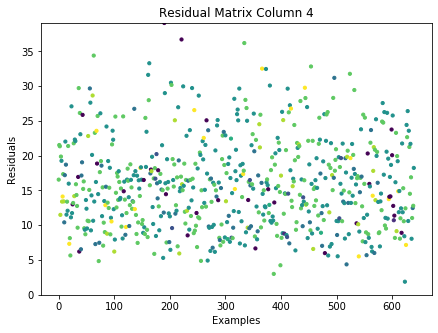

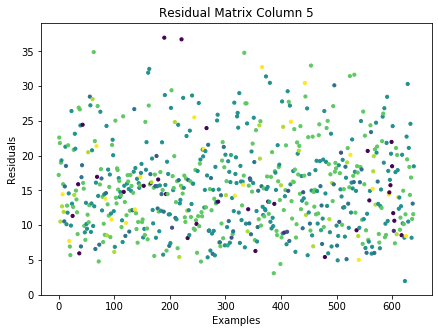

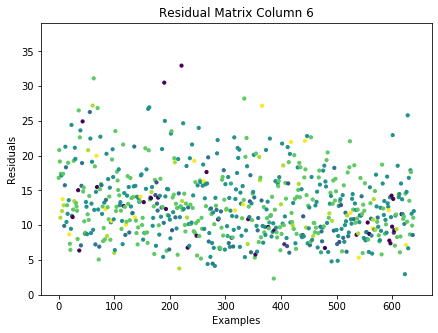

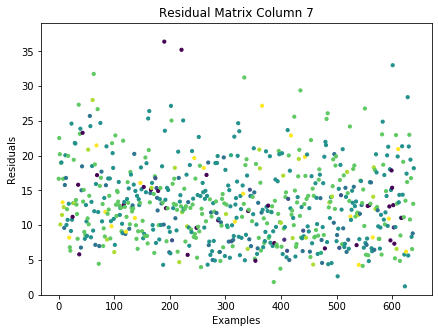

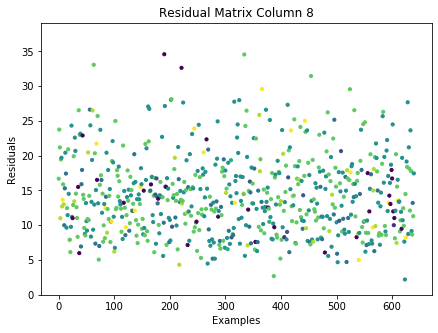

In [13]:
residuals = residuals_set[0]
upperlimit = np.max(residuals)
residuals_permu = residuals[:,rev_permutation2]
count = 0
for col_i in range(args.NumCluster):
    plt.figure(col_i,figsize=(7, 5))
    plt.title("Residual Matrix Column " + str(col_i))
    plt.scatter(np.array(range(len(residuals))), residuals_permu[:,col_i], c = pred_labels_permu_2, s = 10)
    plt.ylim(0, upperlimit)
    plt.xlabel('Examples')
    plt.ylabel('Residuals')

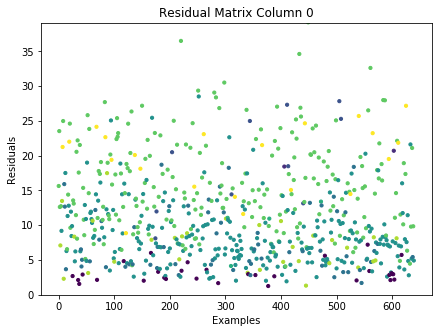

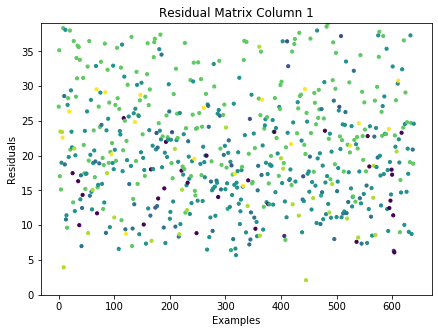

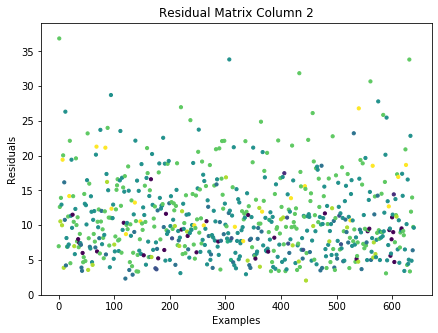

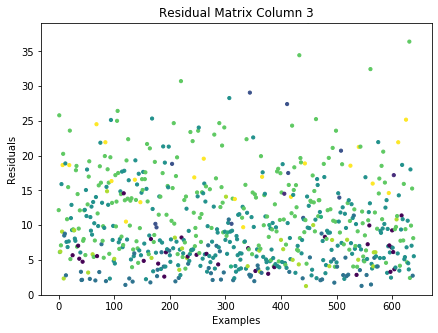

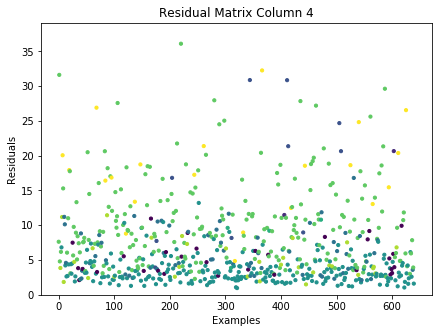

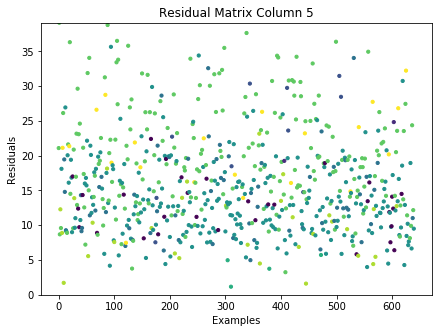

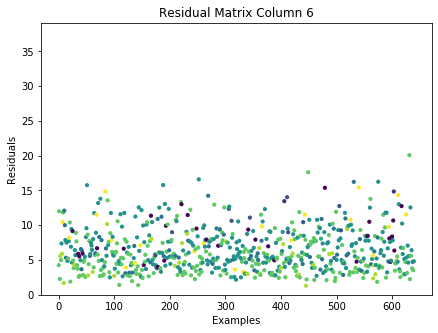

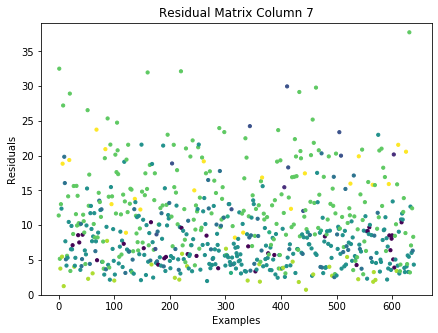

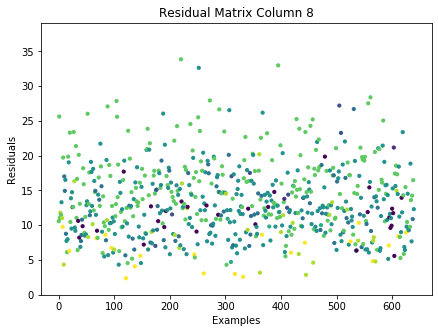

In [14]:
residuals = residuals_set[-1]
residuals_permu = residuals[:,rev_permutation2]
count = 0
for col_i in range(args.NumCluster):
    plt.figure(col_i,figsize=(7, 5))
    plt.title("Residual Matrix Column " + str(col_i))
    plt.scatter(np.array(range(len(residuals))), residuals_permu[:,col_i], c = pred_labels_permu_2, s = 10)
    plt.ylim(0, upperlimit)
    plt.xlabel('Examples')
    plt.ylabel('Residuals')

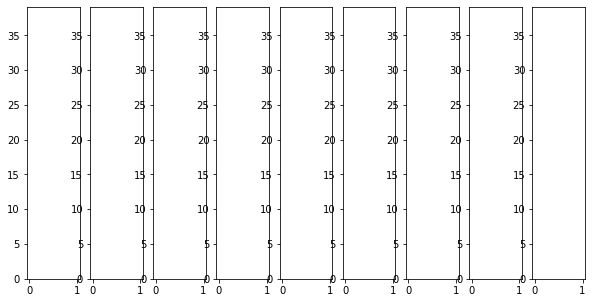

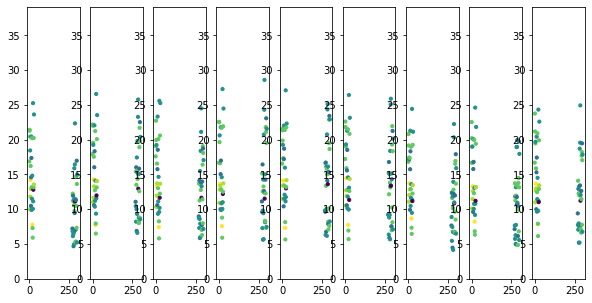

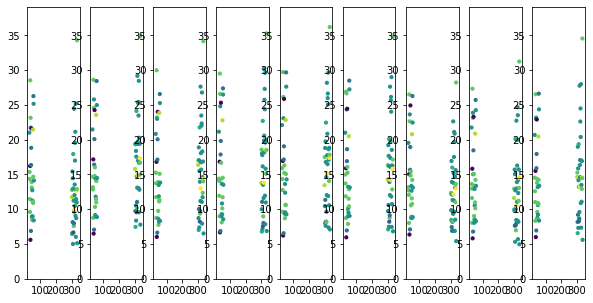

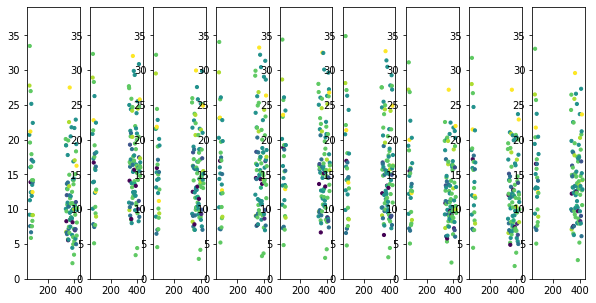

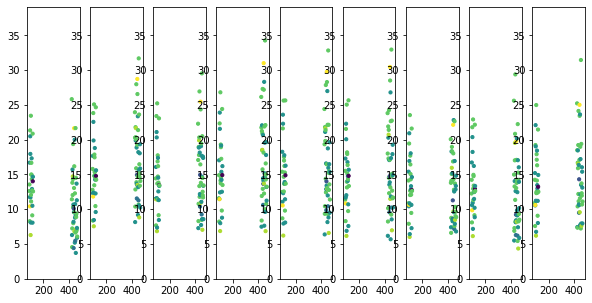

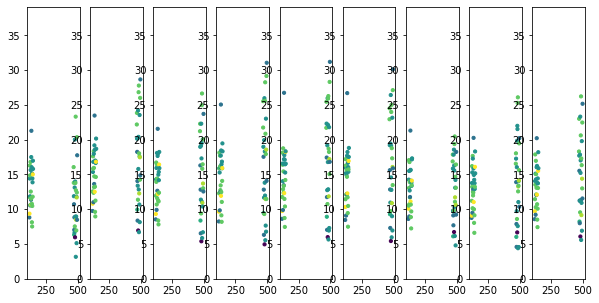

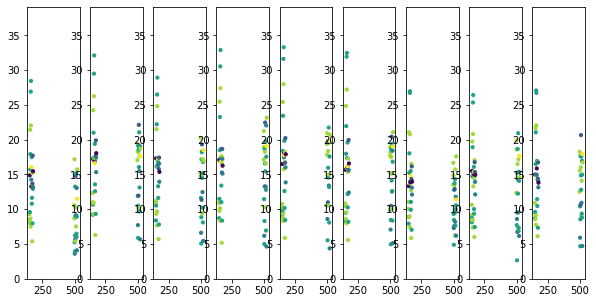

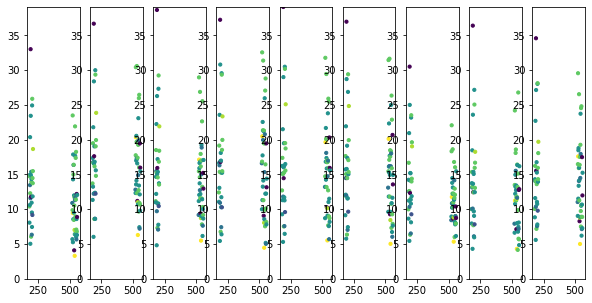

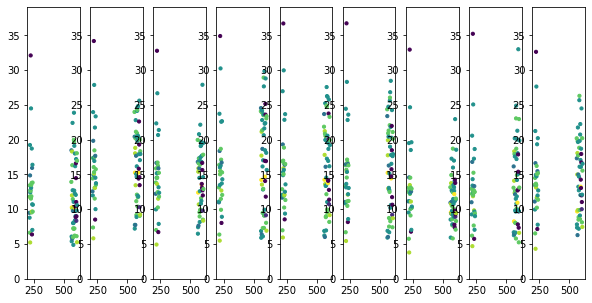

In [15]:
residuals = residuals_set[0]
residuals_permu = residuals[:,rev_permutation2]
count = 0
for cluster_i in range(args.NumCluster):
    plt.figure(cluster_i,figsize=(10, 5))
    plt.title("Cluster " + str(cluster_i))
    for col_i in range(args.NumCluster):
        plot_loc = int('1' + str(args.NumCluster) + str(col_i+1))
        plt.subplot(plot_loc)
        example = np.where(true_labels2==cluster_i)[0]
        plt.scatter(example, residuals_permu[example, col_i], c = pred_labels_permu_2[example], s = 10)
        plt.ylim(0, upperlimit)

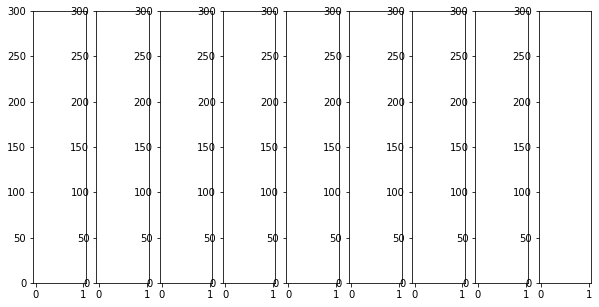

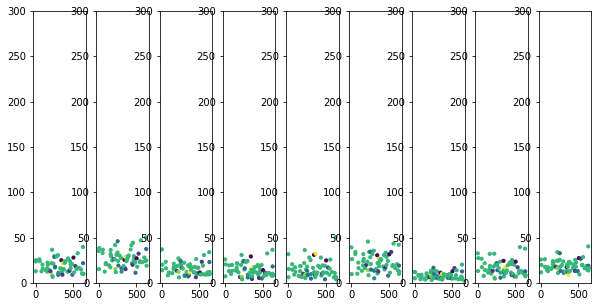

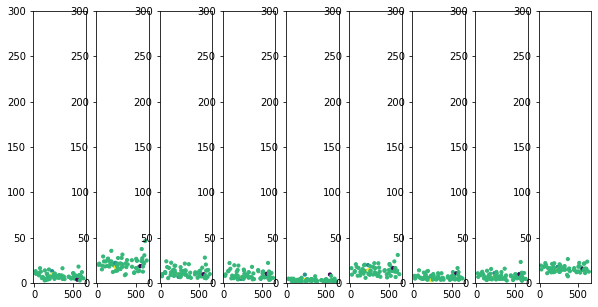

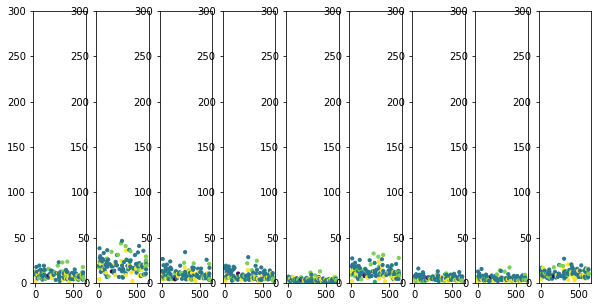

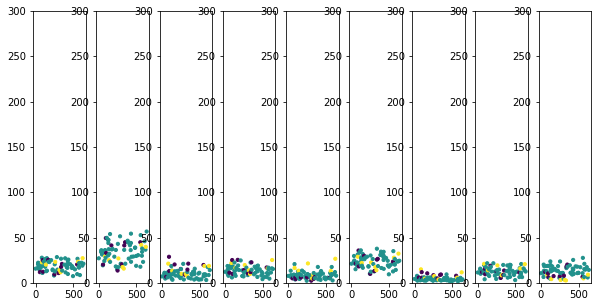

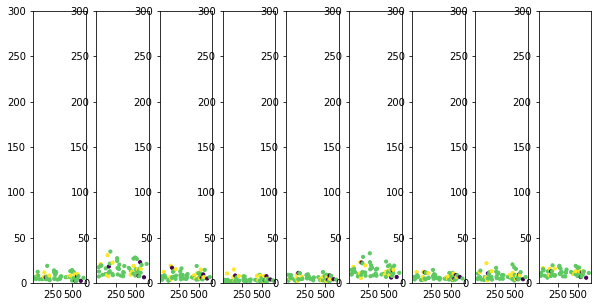

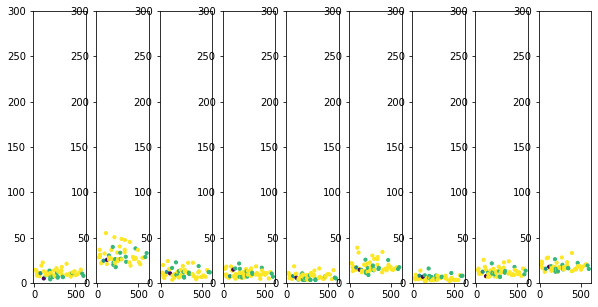

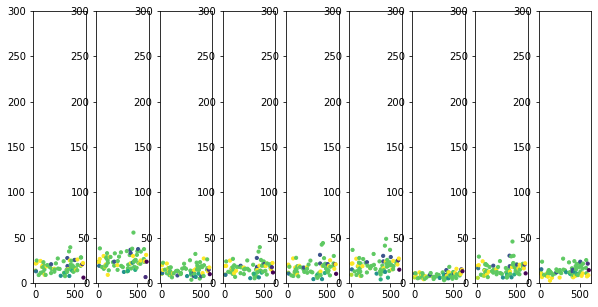

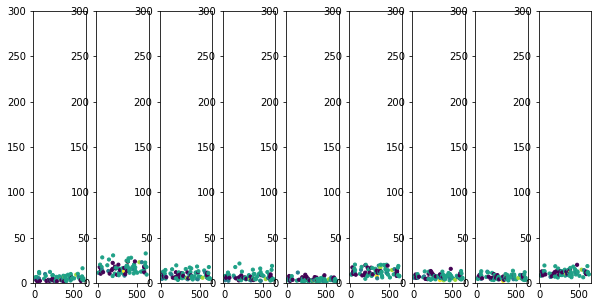

In [16]:
residuals = residuals_set[-1]
residuals_permu = residuals[:,rev_permutation2]
count = 0
for cluster_i in range(args.NumCluster):
    plt.figure(cluster_i, figsize=(10, 5))
    plt.title("Cluster " + str(cluster_i))
    for col_i in range(args.NumCluster):
        plot_loc = int('1' + str(args.NumCluster) + str(col_i+1))
        plt.subplot(plot_loc)
        example = np.where(true_labels1==cluster_i)[0]
        plt.scatter(example, residuals_permu[example, col_i], c = pred_labels_permu_2[example], s = 10)
        plt.ylim(0, 300)
#plt.colorbar()

(array([0.05584426, 0.07309027, 0.05379116, 0.03777699, 0.02422655,
        0.01026549, 0.00492743, 0.00123186, 0.00082124, 0.00082124]),
 array([ 1.2543702,  5.0595956,  8.864821 , 12.670047 , 16.475273 ,
        20.280499 , 24.085724 , 27.89095  , 31.696175 , 35.5014   ,
        39.306625 ], dtype=float32),
 <a list of 10 Patch objects>)

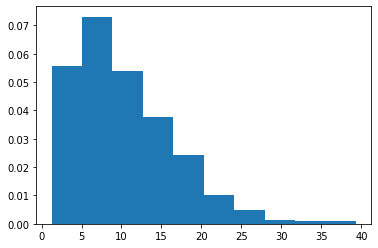

In [17]:
plt.hist(residuals[:,3], density=True)

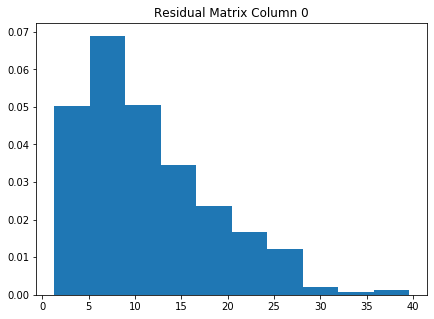

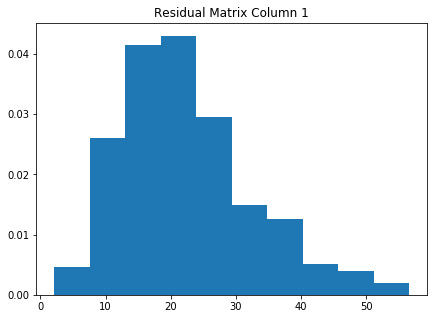

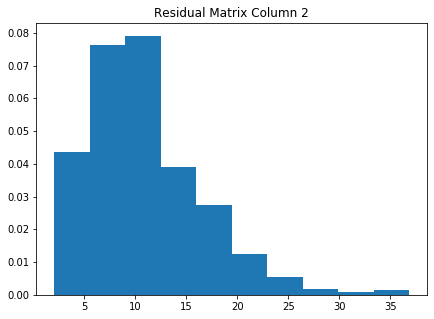

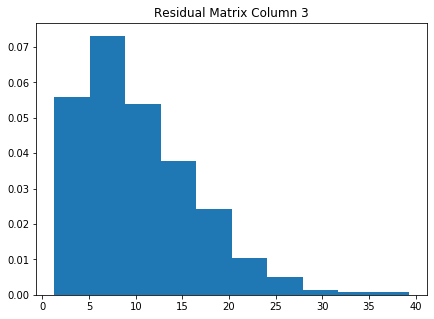

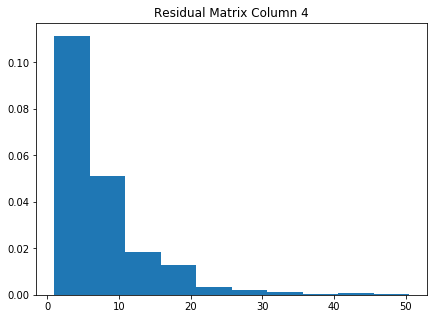

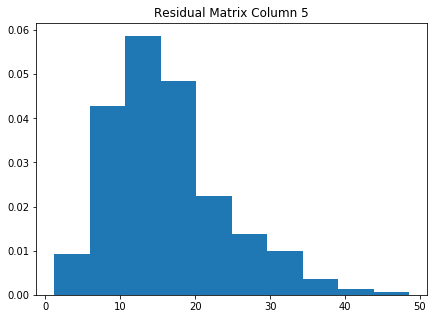

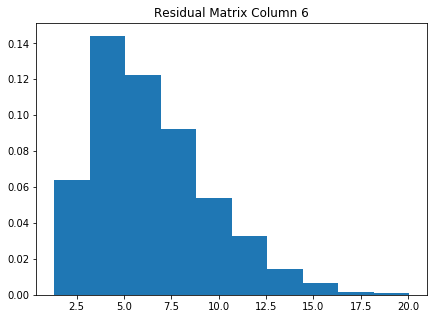

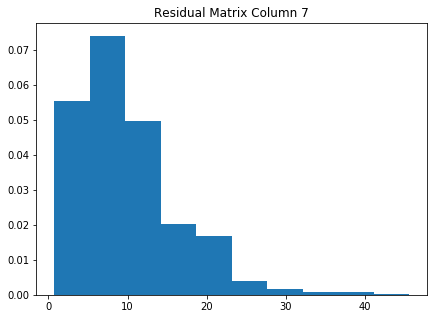

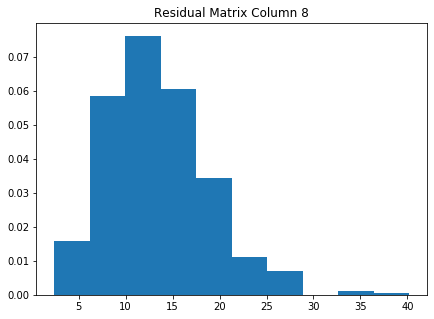

In [18]:
for cluster_i in range(args.NumCluster):
    plt.figure(cluster_i,figsize=(7, 5))
    plt.title("Residual Matrix Column " + str(cluster_i))
    plt.hist(residuals_permu[:,cluster_i], density=True)    
 #   plt.ylim(0, 300)